In [1]:
import arviz as az
import arviz_plots as azp
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns

azp.style.use("arviz-vibrant")

/Users/curro/Documents/Dev/handbook-abc-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  ABC Sequential  Monte Carlo

In [2]:
def gaussian_kernel(u):
    """Gaussian kernel: 1/√(2π) * exp(-u²/2)"""
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * u**2)


def abc_smc(
    key,
    log_prior_density,
    simulator,
    num_particles,
    s_obs,
    distance,
    summary_stat=lambda x: x,
    kernel=gaussian_kernel,
    h=1.0,
    proposal_covariance=None,
    target_ess=0.5,
    num_mcmc_steps=10,
    prior_sample=None,
):
    """
    ABC Sequential Monte Carlo using blackjax's adaptive_tempered_smc.

    The simulator should be wrapped with jax.pure_callback by the user
    for JAX compatibility.

    Args:
        key: JAX random key
        log_prior_density: function log π(θ) computing log prior density
        prior_sample: function (key, num_particles) -> dict of initial particles
        simulator: JAX-compatible function (params) -> y
                  (should be wrapped with jax.pure_callback if using numpy/scipy)
        num_particles: number of particles for SMC
        s_obs: observed summary statistics
        distance: distance function (s_sim, s_obs) -> scalar
        summary_stat: function S(y) computing summary statistics
        kernel: kernel function K(u)
        h: bandwidth parameter for kernel
        proposal_covariance: covariance matrix for proposal
        target_ess: target effective sample size ratio
        num_mcmc_steps: number of MCMC steps per SMC iteration

    Returns:
        az.InferenceData with posterior samples
    """
    import arviz as az
    from blackjax import adaptive_tempered_smc
    from blackjax.smc import resampling, solver

    def inference_loop_mcmc(rng_key, kernel, initial_state, num_samples):
        @jax.jit
        def one_step(state, rng_key):
            state, _ = kernel(rng_key, state)
            return state, state

        keys = jax.random.split(rng_key, num_samples)
        _, states = jax.lax.scan(one_step, initial_state, keys)

        return states

    # Proposal covariance must be provided for SMC
    if proposal_covariance is None:
        raise ValueError("proposal_covariance must be provided")

    # Create ABC loglikelihood (pure JAX)
    s_obs_vec = jnp.atleast_1d(s_obs)

    def mcmc_step(key, state, logdensity):
        """MCMC step using random walk"""
        rw = blackjax.additive_step_random_walk.normal_random_walk(
            logdensity, proposal_covariance
        )
        return rw.step(key, state)

    # Sample initial particles from prior
    key_particles, key_inference = jax.random.split(key)

    # User-provided prior sampling function
    initial_particles = prior_sample(key_particles, num_particles)

    # Initial kernel for first iteration (dummy key, will be replaced in loop)
    def abc_loglik_dummy(params):
        _, subkey = jax.random.split(jax.random.key(0))
        sim = simulator(subkey, params)
        s_sim = jnp.atleast_1d(summary_stat(sim))
        d = distance(s_sim, s_obs_vec)
        k_val = kernel(d / h)
        log_k = jnp.log(k_val)
        return log_k

    kernel_smc_init = adaptive_tempered_smc(
        log_prior_density,
        abc_loglik_dummy,
        mcmc_step,
        blackjax.additive_step_random_walk.normal_random_walk(
            lambda x: 0.0, proposal_covariance
        ).init,
        mcmc_parameters={},
        resampling_fn=resampling.systematic,
        target_ess=target_ess,
        root_solver=solver.dichotomy,
        num_mcmc_steps=num_mcmc_steps,
    )

    # Run SMC inference
    def inference_loop(rng_key, initial_particles):
        """Run SMC until tempering_param reaches 1"""

        def cond(carry):
            _, state, *_ = carry
            return state.tempering_param < 1

        def body(carry):
            i, state, op_key = carry
            op_key, loglik_key, mcmc_key = jax.random.split(op_key, 3)

            # Fresh abc_loglik with its own key each iteration
            def abc_loglik(params):
                _, subkey = jax.random.split(loglik_key)
                sim = simulator(subkey, params)
                s_sim = jnp.atleast_1d(summary_stat(sim))
                d = distance(s_sim, s_obs_vec)
                k_val = kernel(d / h)
                log_k = jnp.log(k_val)
                return log_k

            # Recreate kernel with fresh loglik
            kernel_smc = adaptive_tempered_smc(
                log_prior_density,
                abc_loglik,
                mcmc_step,
                blackjax.additive_step_random_walk.normal_random_walk(
                    lambda x: 0.0, proposal_covariance
                ).init,
                mcmc_parameters={},
                resampling_fn=resampling.systematic,
                target_ess=target_ess,
                root_solver=solver.dichotomy,
                num_mcmc_steps=num_mcmc_steps,
            )

            state, info = kernel_smc.step(mcmc_key, state)
            return (i + 1, state, op_key)

        total_iter, final_state, _ = jax.lax.while_loop(
            cond, body, (0, kernel_smc_init.init(initial_particles), rng_key)
        )
        return final_state.particles

    particles = inference_loop(key_inference, initial_particles)

    # Convert to InferenceData
    posterior = az.from_dict(
        posterior={k: np.asarray(v)[np.newaxis, :] for k, v in particles.items()}
    )

    return posterior

## Example (from the book)

Suppose the model is specified as $y_1, \dots, y_{50} \sim N(\theta, 1)$, with uniform prior $\theta \sim U(-5, 5)$.

In [3]:
theta_true = 2.5
observed_y = dist.Normal(theta_true, 1).sample(jr.key(1), (50,))
observed_y

Array([2.345563  , 2.5847073 , 2.3640194 , 2.3449638 , 3.7666674 ,
       2.6482975 , 4.6415606 , 3.502674  , 2.209664  , 2.8583448 ,
       1.7920727 , 2.2544448 , 3.3855824 , 3.286119  , 3.3889272 ,
       3.0493255 , 3.4658084 , 0.70281506, 3.360454  , 0.8823941 ,
       2.4400551 , 0.99452674, 1.4992719 , 3.1435654 , 0.8084295 ,
       3.0178628 , 3.2885132 , 1.3877132 , 2.0938528 , 1.3641559 ,
       3.613792  , 2.1677556 , 3.005773  , 4.521299  , 2.516674  ,
       4.6386566 , 5.1084757 , 1.2212428 , 3.43114   , 3.4858668 ,
       3.6210191 , 2.5874965 , 4.063922  , 2.7328095 , 3.3074763 ,
       3.0017173 , 3.2227018 , 3.3612227 , 3.760047  , 3.3339958 ],      dtype=float32)

## MCMC (with sufficient summary statistics)

In [4]:
# Define prior distribution
prior = dist.Uniform(-5, 5)
log_prior_density = lambda params: prior.log_prob(params["theta"])


def prior_sample(key, num_particles):
    return {"theta": prior.sample(key, (num_particles,))}


# Sufficient summary statistic
summary_stat = lambda y: jnp.mean(y)

Often, the simulator function cannot be JIT compiled and it's expensive to evaluate. The entire ABC log-density is wrapped with `pure_callback`.

In [5]:
# Wrap simulator with pure_callback for JAX compatibility
def black_box_simulator(key, params):
    import numpy as np

    # Convert JAX random key to numpy seed by extracting bytes
    # The key is a JAX array, extract first integer from it
    key_array = np.asarray(key)
    seed = int(key_array.view(np.uint32).flat[0])
    np.random.seed(seed)
    n_obs = 50
    # Extract scalar value from params["theta"] (handles both scalars and 1D arrays)
    theta_val = float(np.squeeze(np.asarray(params["theta"])))
    y = np.random.normal(theta_val, 1.0, n_obs)
    return jnp.array(y)


# Wrap with pure_callback to make it compatible with JAX transformations
# The callback is called with arguments inside a vmap loop
def simulator(key, params):
    return jax.pure_callback(
        black_box_simulator,
        jax.ShapeDtypeStruct(shape=(50,), dtype=jnp.float32),
        key,
        params,
        vmap_method="sequential",
    )

In [6]:
# Compute observed summary statistics
s_obs = jnp.atleast_1d(summary_stat(observed_y))

# Run ABC-SMC with sufficient summary statistics
posterior_abc_sf = abc_smc(
    key=jr.key(0),
    log_prior_density=log_prior_density,
    prior_sample=prior_sample,
    simulator=simulator,
    num_particles=200,
    s_obs=s_obs,
    distance=lambda s, s_obs: jnp.linalg.norm(s - s_obs, axis=-1),
    summary_stat=summary_stat,
    kernel=gaussian_kernel,
    h=0.1,
    proposal_covariance=jnp.array([[0.1]]),
    target_ess=0.5,
    num_mcmc_steps=30,
)

In [7]:
az.summary(posterior_abc_sf, var_names=["theta"])

arviz - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.878,0.165,2.637,3.231,0.012,0.008,183.0,164.0,NaN


<Axes: ylabel='Density'>

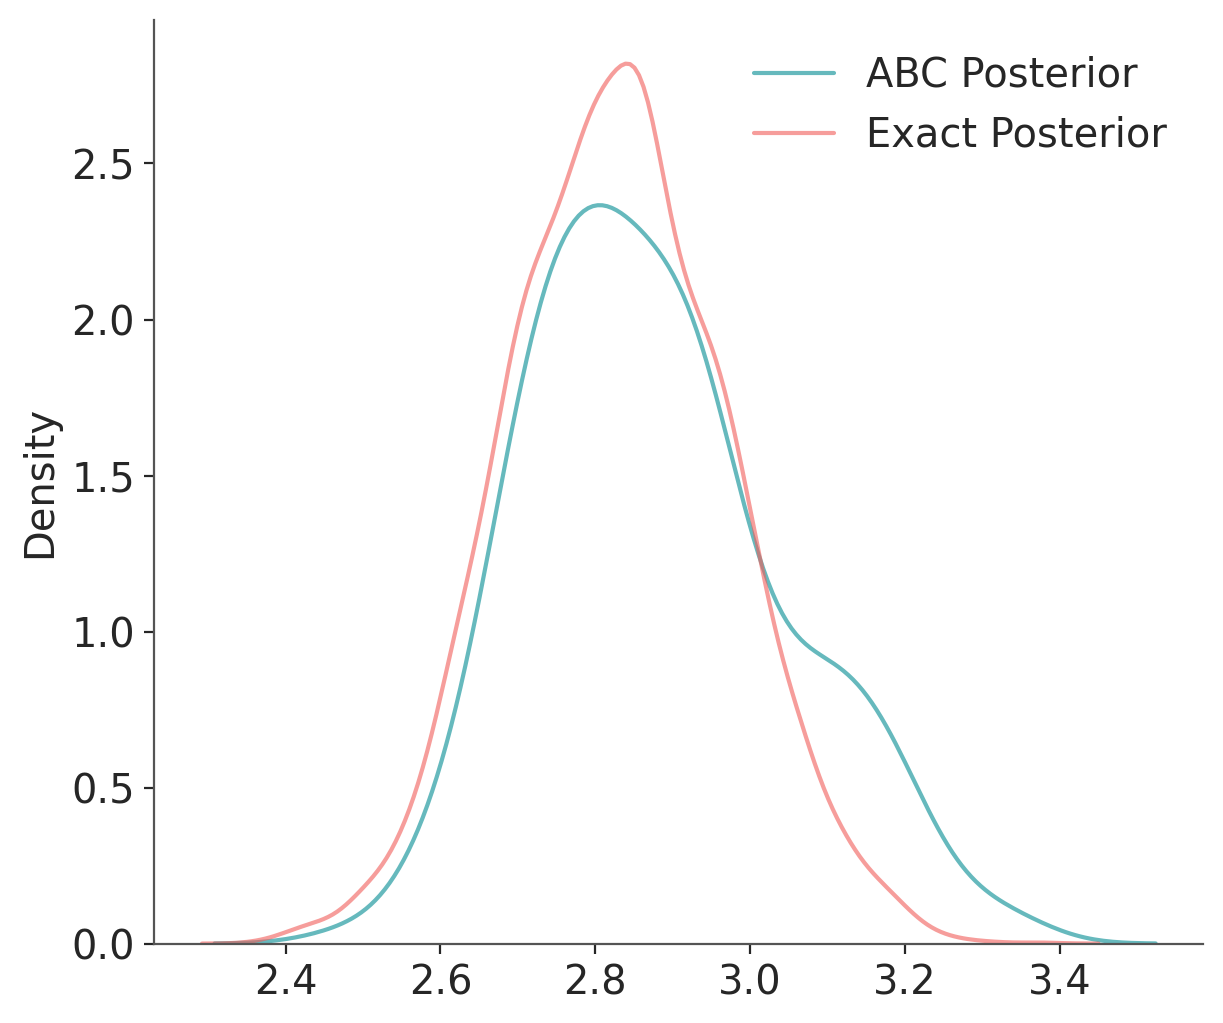

In [8]:
sns.kdeplot(
    posterior_abc_sf.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior",
)
# Ground truth posterior (conjugate normal)
posterior_exact = dist.Normal(observed_y.mean(), 1 / jnp.sqrt(50)).sample(
    jr.key(1), (5000,)
)
posterior_exact = posterior_exact[
    (posterior_exact >= -5) & (posterior_exact <= 5)
]  # Truncate to match uniform prior support
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()

Often, sufficient summary statistics are not available. One popular distance metric between the observed and simulated data is the Wasserstein distance:

In [9]:
# Wrap wasserstein_distance with pure_callback for JAX compatibility
def wasserstein_distance(a, b):
    from scipy.stats import wasserstein_distance as _wasserstein_distance

    def _compute(a, b):
        a_np = np.asarray(a)
        b_np = np.asarray(b)
        # If a is 1D, compute single distance; if 2D, compute batch
        if a_np.ndim == 1:
            return _wasserstein_distance(a_np, b_np)
        else:
            return np.array([_wasserstein_distance(x, b_np) for x in a_np])

    if a.ndim == 1:
        out_shape = jax.ShapeDtypeStruct((), jnp.float32)
    else:
        out_shape = jax.ShapeDtypeStruct((a.shape[0],), jnp.float32)
    return jax.pure_callback(_compute, out_shape, a, b, vmap_method="sequential")

In [10]:
# Run ABC-SMC with Wasserstein distance (no summary statistics)
posterior_abc_ws = abc_smc(
    key=jr.key(42),
    log_prior_density=log_prior_density,
    prior_sample=prior_sample,
    simulator=simulator,
    num_particles=200,
    s_obs=observed_y,
    distance=wasserstein_distance,
    summary_stat=lambda x: x,  # Identity: use raw data
    kernel=gaussian_kernel,
    h=0.2,
    proposal_covariance=jnp.array([[0.1]]),
    target_ess=0.5,
    num_mcmc_steps=30,
)

In [11]:
posterior_abc_ws

Inference data with groups:
	> posterior

<Axes: ylabel='Density'>

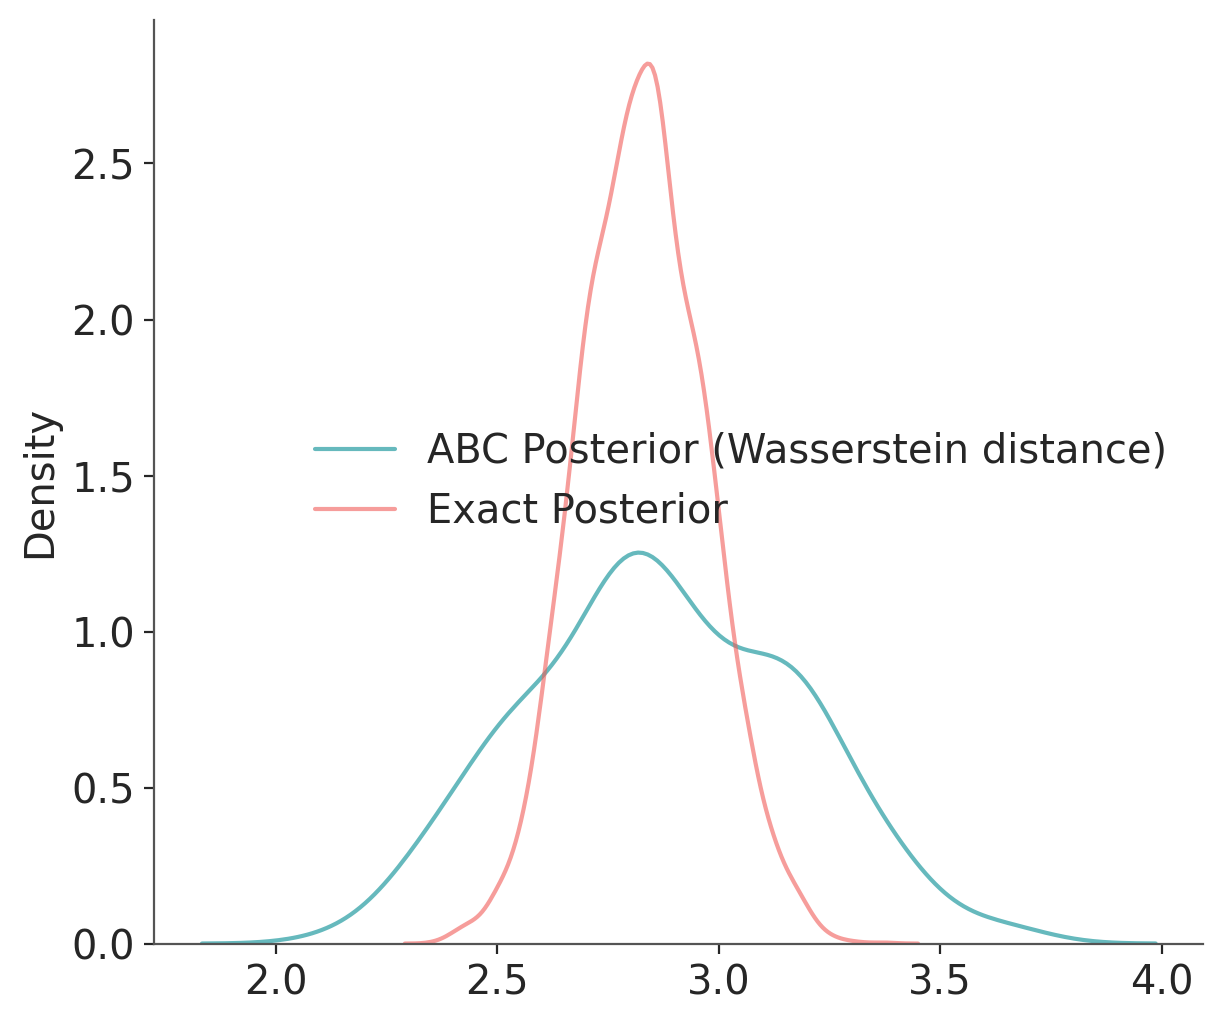

In [12]:
sns.kdeplot(
    posterior_abc_ws.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior (Wasserstein distance)",
)
# Ground truth posterior (conjugate normal)
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()